In [1]:
import os
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
import sys
sys.path.append('../')

In [4]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [5]:
sess = tf.Session()

## Some drawing routines

In [6]:
def colors_subselect(colors, num_classes=8):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)


def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        s = '%s/%.3f' % (classes[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [7]:
colors = colors_subselect(mpcm.plasma.colors, num_classes=8)##############
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40)]#####################

## KITTI dataset

Check the KITTI pipeline and associated TFRecords files.

In [8]:
from datasets import kitti

DATASET_DIR = os.path.join('tfrecords')
SPLIT_NAME = 'test'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = kitti.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, 
                                                          shuffle=False,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bboxes, labels] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources, '|', dataset.num_samples)

('Dataset:', 'tfrecords/kitti_train.tfrecord', '|', 7481)


In [9]:
#images = tf.train.batch(
#               [image_crop],
#               batch_size=BATCH_SIZE,
#                num_threads=1,
#                capacity=5 * BATCH_SIZE)

In [10]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
#print(xy)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])

print('Original vs crop:', image.get_shape(), image_crop.get_shape())

('Original vs crop:', TensorShape([Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(250), Dimension(250), Dimension(3)]))


In [12]:
# with queues.QueueRunners(sess):
# Start populating queues.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess,coord=coord)

In [13]:
# Draw groundtruth bounding boxes using TF routine.
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image) / 255., 0), 
                                                       tf.expand_dims(bboxes, 0)))


Tensor("Squeeze:0", dtype=float32)


('Image shape:', (375, 1242, 3), array([ 375, 1242,    3]))
('Bounding boxes:', array([[ 0.41706666,  0.48261675,  0.50466669,  0.50704509],
       [ 0.48410666,  0.31210145,  0.54165334,  0.34123188],
       [ 0.43720001,  0.54476649,  0.51714665,  0.55473429],
       [ 0.45256001,  0.40570852,  0.50701332,  0.4755314 ],
       [ 0.46656001,  0.41171497,  0.49986666,  0.4249678 ],
       [ 0.47026667,  0.42863929,  0.49405333,  0.43694043],
       [ 0.46888   ,  0.4505797 ,  0.48840001,  0.46328503]], dtype=float32))
('Labels:', array([3, 1, 4, 9, 9, 9, 9]))


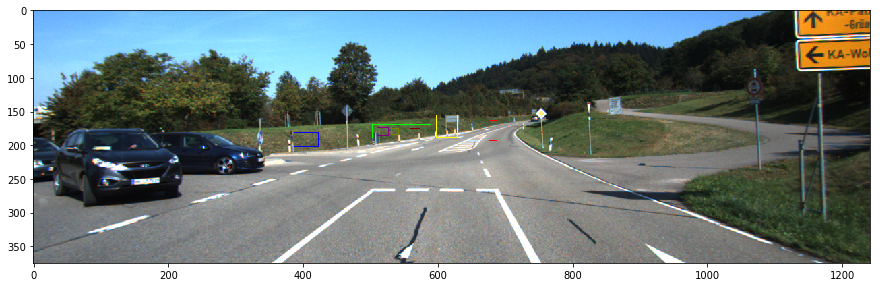

In [16]:
# Eval and display the image + bboxes.
rimg, rshape, rbboxes, rlabels = sess.run([image_bboxes, shape, bboxes, labels])

print('Image shape:', rimg.shape, rshape)
print('Bounding boxes:', rbboxes)
print('Labels:', rlabels)

fig = plt.figure(figsize = (15,15))
plt.imshow(rimg)

# SSD detector on KITTI

Try out the detector on KITTI images.

In [26]:
from nets import ssd_vgg_300
from nets import ssd_common
from nets import np_methods
from preprocessing import ssd_vgg_preprocessing

#ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'
ckpt_filename = './checkpoints/model.ckpt-150000'
#ckpt_filename = '../logs/ssd_300_kitti_4/model.ckpt-2573'
#ckpt_filename = '../logs/ssd_300_kitti_13/model.ckpt-149757'

In [18]:
# Image pre-processimg
out_shape = (None, None) 
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_vgg_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                              resize=ssd_vgg_preprocessing.Resize.NONE)

image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=8)
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [20]:
# Initialize variables.
init_op = tf.global_variables_initializer()
sess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(sess, ckpt_filename)

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-150000


In [24]:
# Run model and get predictions.
print(image_4d)
[rimg, rpredictions, rlocalisations, glabels, gbboxes, rbbox_img] = \
    sess.run([image_4d, predictions, localisations, labels, bboxes_pre, bbox_img])
rimg = rimg[0]

# Update anchor boxes to image size.
ssd.update_feature_shapes(rpredictions)
anchors = ssd.anchors(rimg.shape, dtype=np.float32)

Tensor("ExpandDims_6:0", shape=(1, ?, ?, 3), dtype=float32)


In [30]:
# Compute classes and bboxes from the net outputs.
rclasses, rscores, rbboxes= np_methods.ssd_bboxes_select(rpredictions, rlocalisations, anchors,
                                                               select_threshold=0.8, img_shape=rimg.shape, 
                                                               num_classes=9, decode=True)
rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes,nms_threshold=0.3)

('Labels / scores:', [(1, 0.9994849), (7, 0.97738224), (2, 0.97637504), (7, 0.97498012), (7, 0.97465444), (2, 0.96972793), (7, 0.96629155), (2, 0.96626961), (7, 0.95927864), (7, 0.95632416), (7, 0.95289934), (7, 0.95093203), (1, 0.94257867), (7, 0.94203693), (2, 0.93872213), (7, 0.93293869), (2, 0.93131167), (7, 0.9304176), (7, 0.91329557), (7, 0.90922004), (7, 0.90828562), (2, 0.90494776), (1, 0.89463484), (2, 0.88971418), (2, 0.87930578), (2, 0.87707973), (2, 0.87459135), (2, 0.86638492), (2, 0.84731513), (2, 0.84606063), (2, 0.83261567)])
('Grountruth labels:', [1, 9, 9])
[[ 0.48474666  0.49455717  0.75938666  0.58559579]
 [ 0.61303997  0.00402576  0.98029333  0.17239936]
 [ 0.53960001  0.42049113  0.58589333  0.44103864]]


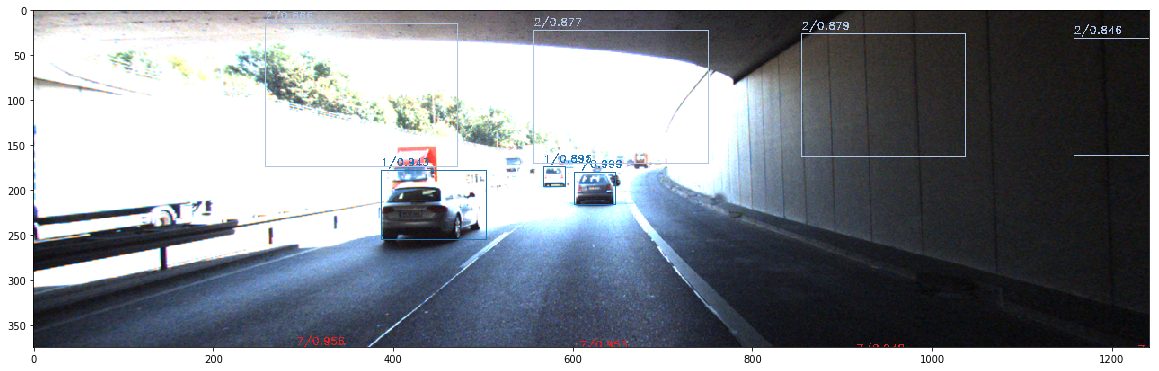

In [31]:
# Draw bboxes
img_bboxes = np.copy(ssd_vgg_preprocessing.np_image_unwhitened(rimg))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)

fig = plt.figure(figsize = (20,20))
plt.imshow(img_bboxes)

In [32]:
~isinstance(rpredictions[0], np.ndarray)

-2

In [33]:
PleaseStopHere;

NameError: name 'PleaseStopHere' is not defined

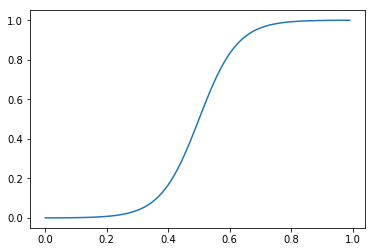

In [34]:
def tanh_weighted(x, w=[1., 1.]):
    r = (w[0]*np.exp(x) - w[1]*np.exp(-x)) / (w[0]*np.exp(x) + w[1]*np.exp(-x))
    return r

x = np.arange(0, 1, 0.01)
y = (tanh_weighted((x - 0.5) * 8, [1, 1]) + 1) / 2.
plt.plot(x, y)

## Test SSD-300 model using TFRecords pipeline

Restore model and test it on some random images coming from Pascal TFRecords.

In [37]:
from nets import ssd_vgg_300
from nets import ssd_common
from nets import np_methods
from preprocessing import ssd_vgg_preprocessing


ckpt_filename = './checkpoints/model.ckpt-150000'

In [39]:
# Image pre-processimg
out_shape = (300, 300) 
image_pre, labels_pre, bboxes_pre, bbox_img = \
    ssd_vgg_preprocessing.preprocess_for_eval(image, labels, bboxes, out_shape, 
                                          resize=ssd_vgg_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# SSD construction.
reuse = True if 'ssd' in locals() else None
params = ssd_vgg_300.SSDNet.default_params
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)
    
# SSD default anchor boxes.
img_shape = out_shape
layers_anchors = ssd.anchors(img_shape, dtype=np.float32)

In [41]:
# Targets encoding.
target_labels, target_localizations, target_scores = ssd_common.tf_ssd_bboxes_encode(labels, bboxes_pre, layers_anchors,8,8)


In [43]:
# Initialize variables.
init_op = tf.global_variables_initializer()
sess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(sess, ckpt_filename)

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-150000


In [45]:
# Run model.
[rimg, rpredictions, rlocalisations, glabels, gbboxes, rbbox_img, rt_labels, rt_localizations, rt_scores] = \
    sess.run([image_4d, predictions, localisations, labels, bboxes_pre, bbox_img, 
               target_labels, target_localizations, target_scores])

InvalidArgumentError: output dimensions must be positive
	 [[Node: ssd_preprocessing_train_1/resize_image/ResizeBilinear = ResizeBilinear[T=DT_FLOAT, align_corners=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ssd_preprocessing_train_1/resize_image/ExpandDims, ssd_preprocessing_train_1/Cast)]]

Caused by op u'ssd_preprocessing_train_1/resize_image/ResizeBilinear', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ahmed/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-7a0508047edd>", line 4, in <module>
    resize=ssd_vgg_preprocessing.Resize.PAD_AND_RESIZE)
  File "preprocessing/ssd_vgg_preprocessing.py", line 346, in preprocess_for_eval
    align_corners=False)
  File "preprocessing/tf_image.py", line 276, in resize_image
    method, align_corners)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/ops/image_ops_impl.py", line 775, in resize_images
    align_corners=align_corners)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_image_ops.py", line 1539, in resize_bilinear
    align_corners=align_corners, name=name)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): output dimensions must be positive
	 [[Node: ssd_preprocessing_train_1/resize_image/ResizeBilinear = ResizeBilinear[T=DT_FLOAT, align_corners=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ssd_preprocessing_train_1/resize_image/ExpandDims, ssd_preprocessing_train_1/Cast)]]


In [ ]:
# Compute classes and bboxes from the net outputs.
rclasses, rscores, rbboxes,_,_ = ssd_common.ssd_bboxes_select(rpredictions, rlocalisations, layers_anchors,
                                                               threshold=0.5, img_shape=img_shape, 
                                                               num_classes=21, decode=True)
rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=False)
rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=0.35)

In [ ]:
# Draw bboxes
img_bboxes = np.copy(ssd_preprocessing.np_image_unwhitened(rimg[0]))
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=1)
# bboxes_draw_on_img(img_bboxes, test_labels, test_scores, test_bboxes, colors_tableau, thickness=1)

print('Labels / scores:', list(zip(rclasses, rscores)))
print('Grountruth labels:', list(glabels))
print(gbboxes)

fig = plt.figure(figsize = (10,10))
plt.imshow(img_bboxes)

In [ ]:
test_bboxes = []
test_labels = []
test_scores = []
for i in range(0, 3):
    yref, xref, href, wref = layers_anchors[i]
    ymin = yref - href / 2.
    xmin = xref - wref / 2.
    ymax = yref + href / 2.
    xmax = xref + wref / 2.
    bb = np.stack([ymin, xmin, ymax, xmax], axis=-1)
    
    idx = yref.shape[0] // 2
    idx = np.random.randint(yref.shape[0])
#     print(bb[idx, idx].shape)
    test_bboxes.append(bb[idx, idx])
    test_labels.append(np.ones(href.shape, dtype=np.int64) * i)
    test_scores.append(np.ones(href.shape))

test_bboxes = np.concatenate(test_bboxes)
test_labels = np.concatenate(test_labels)
test_scores = np.concatenate(test_scores)

print(test_bboxes.shape)
print(test_labels.shape)
print(test_scores.shape)


In [ ]:
rt_labels, rt_localizations, rt_scores
for i in range(len(rt_labels)):
    print(rt_labels[i].shape)
    idxes = np.where(rt_labels[i] > 0)
#     idxes = np.where(rt_scores[i] > 0.)
    print(idxes)
    print(rt_localizations[i][idxes])
    print(list(zip(rt_labels[i][idxes], rt_scores[i][idxes])))
    print()

In [ ]:
# fig = plt.figure(figsize = (8,8))
# plt.imshow(ssd_preprocessing.np_image_unwhitened(rimg[0]))
# print('Ground truth labels: ', rlabels)

In [ ]:
# Request threads to stop. Just to avoid error messages
# coord.request_stop()
# coord.join(threads)

In [ ]:
PleaseStopHere;

## Test SSD-300 model using sample images

Restore model and test it on some sample images.

In [47]:
# Input placeholder.
net_shape = (300, 300)
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, labels, None, net_shape, resize=ssd_vgg_preprocessing.Resize.PAD_AND_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Re-define the model
reuse = True if 'ssd' in locals() else None
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [51]:
# Main processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=0.35, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = sess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    # Compute classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, layers_anchors,
            threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
#     print(list(zip(classes, scores)))
#     print(rlayers)
#     print(ridxes)
    
    rbboxes = ssd_common.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    rclasses, rscores, rbboxes = ssd_common.bboxes_nms(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Resize bboxes to original image shape.
    rbboxes = ssd_common.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes
    

In [53]:
# Test on demo images.
path = 'demo/'
image_names = sorted(os.listdir(path))
img = mpimg.imread(path + image_names[3])

rclasses, rscores, rbboxes =  process_image(img)

# Draw results.
img_bboxes = np.copy(img)
bboxes_draw_on_img(img_bboxes, rclasses, rscores, rbboxes, colors_tableau, thickness=2)

fig = plt.figure(figsize = (12, 12))
plt.imshow(img_bboxes)

[[[170 154 157]
  [168 150 158]
  [161 153 157]
  ..., 
  [ 18  16  17]
  [ 21  17  24]
  [ 24  21  23]]

 [[171 165 153]
  [171 159 150]
  [166 156 148]
  ..., 
  [ 22  19  19]
  [ 22  22  27]
  [ 22  23  26]]

 [[180 162 154]
  [181 164 149]
  [169 163 145]
  ..., 
  [ 22  23  28]
  [ 21  21  37]
  [ 21  17  32]]

 ..., 
 [[ 34  33  56]
  [ 35  34  47]
  [ 33  32  43]
  ..., 
  [ 13  11  15]
  [ 10   9  16]
  [  8   6  13]]

 [[ 36  33  43]
  [ 36  32  43]
  [ 33  34  44]
  ..., 
  [ 13  14  17]
  [ 11  13  15]
  [  8  12  18]]

 [[ 31  33  39]
  [ 30  30  43]
  [ 27  30  44]
  ..., 
  [ 14  13  18]
  [ 13  10  16]
  [ 10  12  18]]]


InvalidArgumentError: output dimensions must be positive
	 [[Node: ssd_preprocessing_train_2/resize_image/ResizeBilinear = ResizeBilinear[T=DT_FLOAT, align_corners=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ssd_preprocessing_train_2/resize_image/ExpandDims, ssd_preprocessing_train_2/Cast)]]

Caused by op u'ssd_preprocessing_train_2/resize_image/ResizeBilinear', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/ahmed/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-87fc9afbc955>", line 5, in <module>
    img_input, labels, None, net_shape, resize=ssd_vgg_preprocessing.Resize.PAD_AND_RESIZE)
  File "preprocessing/ssd_vgg_preprocessing.py", line 346, in preprocess_for_eval
    align_corners=False)
  File "preprocessing/tf_image.py", line 276, in resize_image
    method, align_corners)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/ops/image_ops_impl.py", line 775, in resize_images
    align_corners=align_corners)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_image_ops.py", line 1539, in resize_bilinear
    align_corners=align_corners, name=name)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ahmed/.virtualenvs/cv/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): output dimensions must be positive
	 [[Node: ssd_preprocessing_train_2/resize_image/ResizeBilinear = ResizeBilinear[T=DT_FLOAT, align_corners=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ssd_preprocessing_train_2/resize_image/ExpandDims, ssd_preprocessing_train_2/Cast)]]


In [ ]:
idxes = np.where(inside)
rscores[idxes]

## Some TensorFlow tests...

In [ ]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

## A few tests on Caffe model files...

In [ ]:
import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)


In [ ]:
layers = caffemodel_params.layer
names = [(i, l.name) for i, l in enumerate(layers)]
types = set([l.type for i, l in enumerate(layers)])
print(types)
names

In [ ]:
layer = layers[59]
layer = layers[1]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape
print(s, 38*38)
# print(a)

In [ ]:
from nets import caffe_scope

In [ ]:
csc = caffe_scope.CaffeScope()

In [ ]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [ ]:
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']
min_ratio = 15
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

In [ ]:
print(min_sizes)
print(max_sizes)

In [ ]:
feat_shapes=[(38, 38), (19, 19), (10, 10), (5, 5), (3, 3), (1, 1)]

In [ ]:
steps = [8, 16, 32, 64, 100, 300]
offset = 0.5

In [ ]:
for i in range(len(steps)):
    print((feat_shapes[i][0] - offset) * steps[i] / 300, (feat_shapes[i][0] - offset) / feat_shapes[i][0])

In [ ]:
37.5 * 8. / 300

In [ ]:
.5 / 38

In [ ]:
~True